# Images of satellites classification

In [1]:
from google_images_download import google_images_download   #importing the library
import pandas
import cv2 #to load and displays images
import matplotlib.pyplot as plt
import imutils
import os
import pandas as pd

## Download images of satellites / non satellites

In [2]:
nb_images = 2000 # The number of images to download (both from satellite and non satellite images)
download = False  # Are we doanloading the images ?
chromeDriverPath = "/usr/bin/chromedriver"

In [3]:
def downloadImages(tags, nbImgs):
    response = google_images_download.googleimagesdownload()   #class instantiation

    arguments = {"keywords":','.join(tags),"limit":nbImgs,"print_urls":False, "extract_metadata":True, "thumbnail_only":True, "chromedriver":chromeDriverPath}   #creating list of arguments
    if download:
        response.download(arguments)   #passing the arguments to the function

download list of satellites categories

In [4]:
# categories taken from https://www.omicsonline.org/conferences-list/types-of-satellites-and-applications
categories = ["Communications Satellite","Remote Sensing Satellite","Navigation Satellite","LEO satellite", 
              "MEO satellite", "HEO satellite","GPS satellite","GEO satellite","Drone Satellite",
              "Polar Satellite","Nano Satellites","CubeSats","SmallSats"]

In [5]:
downloadImages(categories, nb_images)

In [6]:
catpd = [pandas.read_json("logs/" + str(cat) + ".json") for cat in categories]

### download of images

In [7]:
downloadImages(["satellite","images"], nb_images)

In [8]:
imgpd = pandas.read_json("logs/images.json")
satpd = pandas.read_json("logs/satellite.json")

In [9]:
imgpd.image_filename.count(), satpd.image_filename.count()

(397, 398)

In [10]:
satpd.iloc[0]

image_description      Virgin Orbit Tests its Satellite-Delivery Rock...
image_filename                          virgin-orbit-first-release-2.jpg
image_format                                                         jpg
image_height                                                         615
image_host                                             universetoday.com
image_link             https://www.universetoday.com/wp-content/uploa...
image_source           https://www.universetoday.com/142812/virgin-or...
image_thumbnail_url    https://encrypted-tbn0.gstatic.com/images?q=tb...
image_width                                                         1000
Name: 0, dtype: object

### display of the first images

In [11]:
def draw_imgs(imgs_list):
    l = int(len(imgs_list))
    n = int(len(imgs_list[0]))
    _, axs = plt.subplots(l, n, figsize=(17, 17))
    axs = axs.flatten()
    for img, ax in zip([item for sublist in imgs_list for item in sublist], axs):
        ax.imshow(img)
    plt.show()

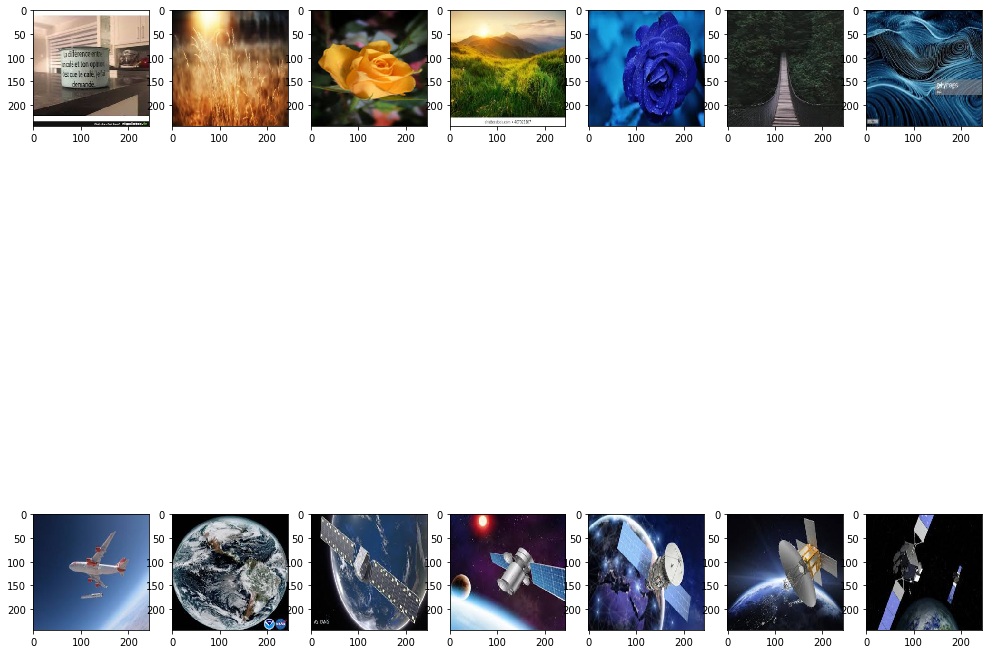

In [12]:
listnonsat = []
for i in range(0,7):
    img =cv2.imread("./downloads/images - thumbnail/"+imgpd.image_filename[i])
    img = cv2.resize(img, (244,244), cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    listnonsat.append(img)
    
listsat = []
for i in range(0,7):
    img =cv2.imread("./downloads/satellite - thumbnail/"+satpd.image_filename[i])
    img = cv2.resize(img, (244,244), cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    listsat.append(img)
    
draw_imgs([listnonsat, listsat])



Communications Satellite
Remote Sensing Satellite
Navigation Satellite
LEO satellite
MEO satellite
HEO satellite
GPS satellite
GEO satellite
Drone Satellite
Polar Satellite
Nano Satellites
CubeSats
SmallSats


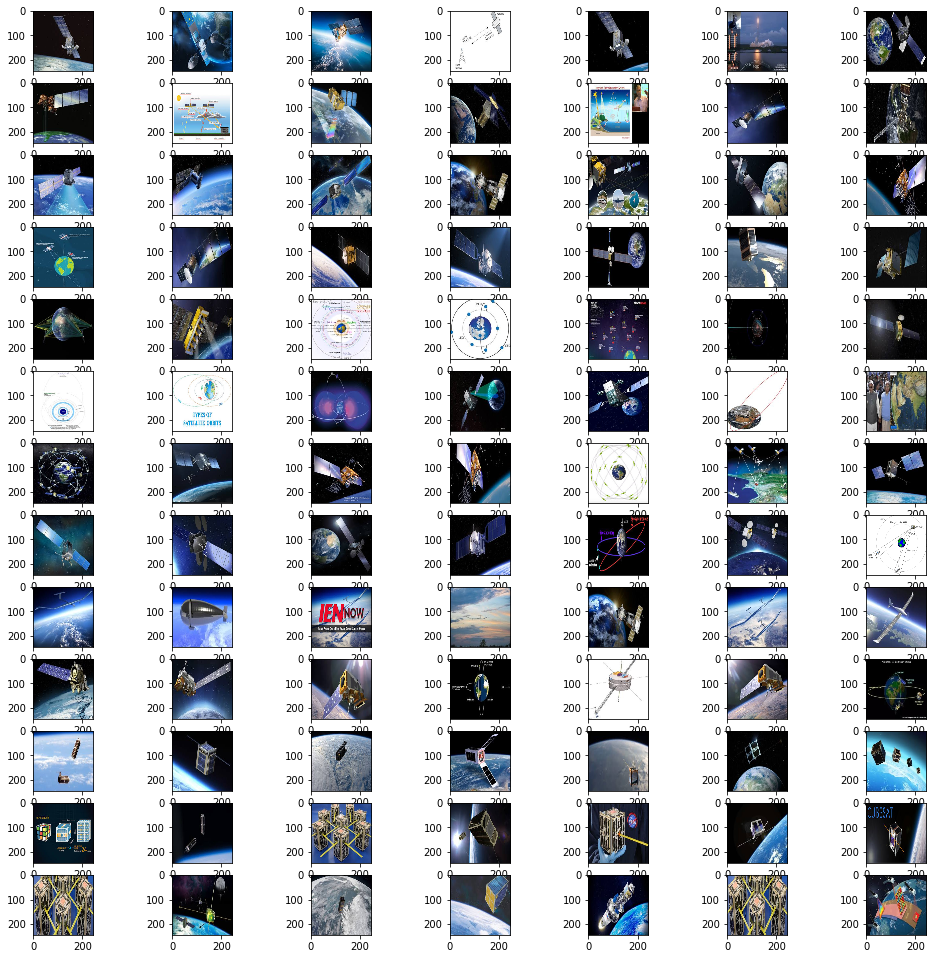

In [13]:
listcat = []
for current,cat in zip(catpd, categories):
    print(cat)
    listcurrent = []
    for i in range(0,7):
        img =cv2.imread("./downloads/"+str(cat)+" - thumbnail/"+current.image_filename[i])
        img = cv2.resize(img, (244,244), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        listcurrent.append(img)
    listcat.append(listcurrent)
    
draw_imgs(listcat)

## Classify satellite images

In [14]:
#saving images in the right directories for keras CNN

train_size = 200
test_size = 100

try:
    os.mkdir("./classification")
    os.mkdir("./classification/test")
    os.mkdir("./classification/test/images")
    os.mkdir("./classification/test/satellite")
    os.mkdir("./classification/train")
    os.mkdir("./classification/train/images")
    os.mkdir("./classification/train/satellite")
    os.mkdir("./classification/valid")
    os.mkdir("./classification/valid/images")
    os.mkdir("./classification/valid/satellite")
except:
    print("directories already in place")

def path_from_number(n):
    if i<=train_size:
        path="train"
    else:
        if i<=train_size+test_size:
            path = "test"
        else:
            path = "valid"
    return path

listnonsat = []
for i in range(0,imgpd.shape[0]):
    try:
        img =cv2.imread("./downloads/images - thumbnail/"+imgpd.image_filename[i])
        img = cv2.resize(img, (64,64), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite("./classification/" + path_from_number(i)+"/images/"+str(i)+".jpg", img)
        listnonsat.append(img)
    except:
        print("image not resizable")
    
listsat = []
for i in range(0,satpd.shape[0]):
    try:
        img =cv2.imread("./downloads/satellite - thumbnail/"+satpd.image_filename[i])
        img = cv2.resize(img, (64,64), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)         
        cv2.imwrite("./classification/" + path_from_number(i)+"/satellite/"+str(i)+".jpg", img)
        listsat.append(img)
    except:
        print("image not resizable")
    

directories already in place
image not resizable
image not resizable


In [15]:
len(listnonsat), len(listsat)

(396, 397)

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import time
IMG_SIZE = 64 # Replace with the size of your images
NB_CHANNELS = 3 # 3 for RGB images or 1 for grayscale images
BATCH_SIZE = 32 # Typical values are 8, 16 or 32
NB_TRAIN_IMG = 200 # Replace with the total number training images
NB_VALID_IMG = 50 # Replace with the total number validation images


/home/franck/data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [17]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, 
               kernel_size=(2,2), 
               strides=(1,1),
               padding='same',
               input_shape=(IMG_SIZE,IMG_SIZE,NB_CHANNELS),
               data_format='channels_last'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Conv2D(filters=64,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Conv2D(filters=128,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Flatten())        
cnn.add(Dense(32))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       32896     
__________

In [19]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'classification/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'classification/valid',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')


Found 400 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [ ]:
cnn.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=80)

Epoch 1/20
 29/100 [=======>......................] - ETA: 27s - loss: 0.6128 - acc: 0.6940

In [ ]:
cnn.save_weights('cnn.h5')

In [ ]:
cnn.load_weights('cnn.h5')

In [ ]:
test_generator = test_datagen.flow_from_directory(
        'classification/test',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')
test_imgs, test_labels = next(test_generator)

In [ ]:
test_imgs.shape

In [ ]:
predictions = cnn.predict_generator(test_generator, steps=1)

In [ ]:
predictions.shape

In [ ]:
# check satellites
for i in range(0,predictions.shape[0]):
    if predictions[i]>0.5:
        plt.figure()
        plt.imshow(test_imgs[i])

In [ ]:
# check non satellites
for i in range(0,predictions.shape[0]):
    if predictions[i]<0.5:
        plt.figure()
        plt.imshow(test_imgs[i])

## filtering specific satellites datasets

In [ ]:
try:
    os.mkdir("./specific")
    os.mkdir("./specific/Remote Sensing Satellite")
except:
    print("directory exists")
    
listspecific = []
for i in range(0,catpd[1].shape[0]):
    try:
        img =cv2.imread("./downloads/Remote Sensing Satellite - thumbnail/"+catpd[1].image_filename[i])
        img = cv2.resize(img, (64,64), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite("./specific/Remote Sensing Satellite/"+str(i)+".jpg", img)
        listspecific.append(img)
    except:
        print("image not resizable")
        
draw_imgs([listspecific])

In [ ]:
specific_generator = test_datagen.flow_from_directory(
        'specific',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')
specific_imgs, specific_labels = next(specific_generator)

In [ ]:
specific_predictions = cnn.predict_generator(specific_generator, steps=1)

In [ ]:
# check satellites
for i in range(0,specific_predictions.shape[0]):
    if specific_predictions[i]>0.5:
        plt.figure()
        plt.imshow(specific_imgs[i])

In [ ]:
# check non satellites
for i in range(0,specific_predictions.shape[0]):
    if specific_predictions[i]<0.5:
        plt.figure()
        plt.imshow(specific_imgs[i])

In [ ]:
pd.Series(specific_predictions.transpose()[0]).hist()